In [1]:
pip install pandas seaborn matplotlib numpy tensorflow datasets scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_dataset = pd.DataFrame(dataset["train"])
validate_dataset = pd.DataFrame(dataset["validation"])
test_dataset = pd.DataFrame(dataset["test"])

Found cached dataset parquet (/Users/shubhamchoudhary/.cache/huggingface/datasets/surrey-nlp___parquet/surrey-nlp--PLOD-CW-843ef47e3e665cc1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
def visualize_data(data):
    ner_counts = {}
    for ner_tags in data['ner_tags']:
        for ner_tag in ner_tags:
            if ner_tag in ner_counts:
                ner_counts[ner_tag] += 1
            else:
                ner_counts[ner_tag] = 1
    
    plt.figure(figsize=(10, 5))
    plt.bar(ner_counts.keys(), ner_counts.values(), color='purple')
    plt.xlabel('NER Tags')
    plt.ylabel('Count')
    plt.title('Occurrences of NER Tags')
    plt.xticks(rotation=45)
    plt.show()

visualize_data(train_dataset)

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [6]:
# Tokenizer and padding sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_dataset["tokens"].apply(" ".join))
max_length = max([len(tokens) for tokens in train_dataset["tokens"]])

def preprocess_data(dataset):
    sequences = tokenizer.texts_to_sequences(dataset["tokens"].apply(" ".join))
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

X_train = preprocess_data(train_dataset)
X_validate = preprocess_data(validate_dataset)
X_test = preprocess_data(test_dataset)

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_dataset["ner_tags"])
y_validate = mlb.transform(validate_dataset["ner_tags"])
y_test = mlb.transform(test_dataset["ner_tags"])

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

In [8]:
train_tokens = [' '.join(instance) for instance in train_dataset["tokens"]]
validate_tokens = [' '.join(instance) for instance in validate_dataset["tokens"]]
test_tokens = [' '.join(instance) for instance in test_dataset["tokens"]]

In [9]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_tokens)
X_validate_tfidf = tfidf_vectorizer.transform(validate_tokens)
X_test_tfidf = tfidf_vectorizer.transform(test_tokens)

In [10]:
decision_tree = DecisionTreeClassifier()
classifier = MultiOutputClassifier(decision_tree, n_jobs=-1)
classifier.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier(), n_jobs=-1)

In [11]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, multilabel_confusion_matrix
import seaborn as sns

# Predict and evaluate
validate_predictions = classifier.predict(X_validate_tfidf)
test_predictions = classifier.predict(X_test_tfidf)

validate_accuracy = accuracy_score(y_validate, validate_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Validation Accuracy:", validate_accuracy)
print("Test Accuracy:", test_accuracy)

print("Validation Classification Report:")
print(classification_report(y_validate, validate_predictions, target_names=mlb.classes_))

print("Test Classification Report:")
print(classification_report(y_test, test_predictions, target_names=mlb.classes_))

Validation Accuracy: 0.4365079365079365
Test Accuracy: 0.5098039215686274
Validation Classification Report:
              precision    recall  f1-score   support

        B-AC       0.93      0.81      0.87       116
        B-LF       0.83      0.70      0.76       101
         B-O       1.00      1.00      1.00       126
        I-LF       0.74      0.74      0.74        90

   micro avg       0.89      0.83      0.86       433
   macro avg       0.88      0.81      0.84       433
weighted avg       0.89      0.83      0.85       433
 samples avg       0.90      0.85      0.83       433

Test Classification Report:
              precision    recall  f1-score   support

        B-AC       0.91      0.86      0.89       131
        B-LF       0.82      0.75      0.78       113
         B-O       1.00      1.00      1.00       153
        I-LF       0.77      0.75      0.76       100

   micro avg       0.89      0.86      0.87       497
   macro avg       0.87      0.84      0.86      

In [12]:
validation_f1_micro = f1_score(y_validate, validate_predictions, average='micro')
validation_f1_macro = f1_score(y_validate, validate_predictions, average='macro')
test_f1_micro = f1_score(y_test, test_predictions, average='micro')
test_f1_macro = f1_score(y_test, test_predictions, average='macro')

print("Validation F1 Score (Micro):", validation_f1_micro)
print("Validation F1 Score (Macro):", validation_f1_macro)
print("Test F1 Score (Micro):", test_f1_micro)
print("Test F1 Score (Macro):", test_f1_macro)

Validation F1 Score (Micro): 0.8564593301435407
Validation F1 Score (Macro): 0.8425405450547766
Test F1 Score (Micro): 0.8729508196721311
Test F1 Score (Macro): 0.8568151014071317


In [13]:
validation_multilabel_conf_matrix = multilabel_confusion_matrix(y_validate, validate_predictions)
test_multilabel_conf_matrix = multilabel_confusion_matrix(y_test, test_predictions)

print("Multilabel Confusion Matrix for Validation Set:")
for i, label in enumerate(mlb.classes_):
    print(f"Confusion matrix for label '{label}':")
    print(validation_multilabel_conf_matrix[i])
    print()

print("Multilabel Confusion Matrix for Test Set:")
for i, label in enumerate(mlb.classes_):
    print(f"Confusion matrix for label '{label}':")
    print(test_multilabel_conf_matrix[i])
    print()

Multilabel Confusion Matrix for Validation Set:
Confusion matrix for label 'B-AC':
[[ 3  7]
 [22 94]]

Confusion matrix for label 'B-LF':
[[10 15]
 [30 71]]

Confusion matrix for label 'B-O':
[[  0   0]
 [  0 126]]

Confusion matrix for label 'I-LF':
[[13 23]
 [23 67]]

Multilabel Confusion Matrix for Test Set:
Confusion matrix for label 'B-AC':
[[ 11  11]
 [ 18 113]]

Confusion matrix for label 'B-LF':
[[21 19]
 [28 85]]

Confusion matrix for label 'B-O':
[[  0   0]
 [  0 153]]

Confusion matrix for label 'I-LF':
[[30 23]
 [25 75]]



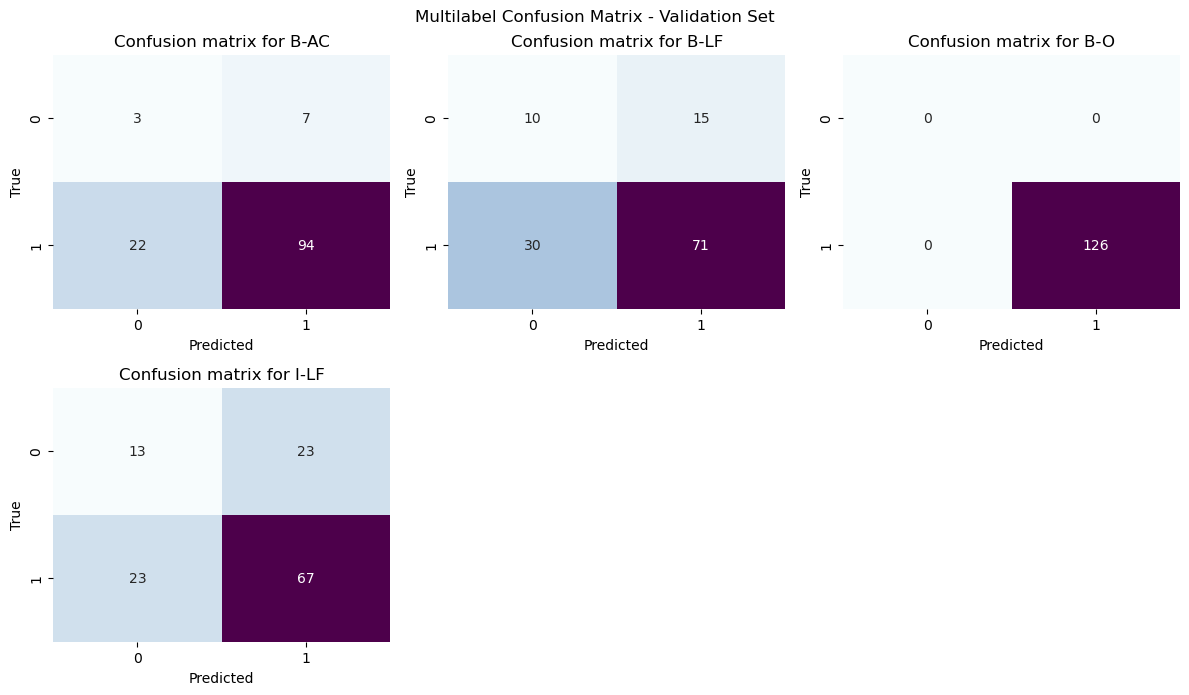

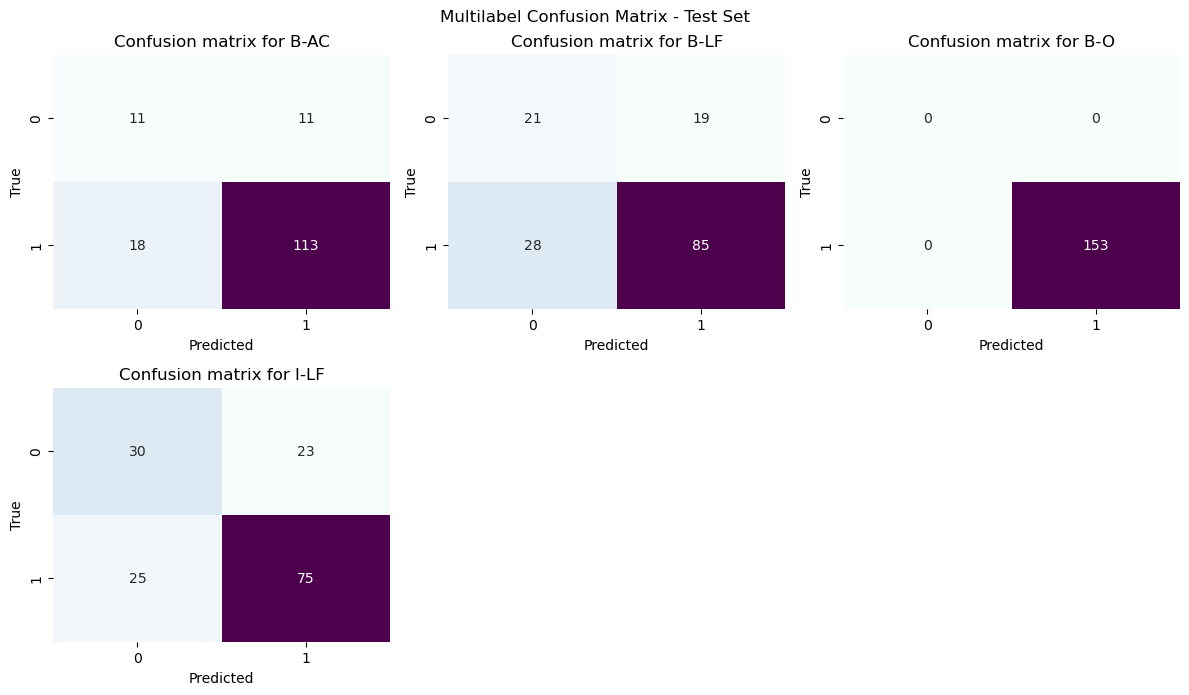

In [14]:
def plot_multilabel_confusion_matrix(conf_matrix, classes, title):
    plt.figure(figsize=(12, 10))
    for i in range(len(classes)):
        plt.subplot(3, 3, i + 1)
        sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="BuPu", cbar=False)
        plt.title(f'Confusion matrix for {classes[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_multilabel_confusion_matrix(validation_multilabel_conf_matrix, mlb.classes_, 'Multilabel Confusion Matrix - Validation Set')
plot_multilabel_confusion_matrix(test_multilabel_conf_matrix, mlb.classes_, 'Multilabel Confusion Matrix - Test Set')

In [16]:
import numpy as np

In [19]:
def error_analysis(true_labels, predicted_labels):
    errors = []
    for true_label, pred_label in zip(true_labels, predicted_labels):
        if not np.array_equal(true_label, pred_label):
            errors.append((np.array(true_label), np.array(pred_label)))
    return errors

validation_errors = error_analysis(y_validate, validate_predictions)
test_errors = error_analysis(y_test, test_predictions)

print("\nValidation Errors:")
for error in validation_errors[:10]:
    true_label, predicted_label = error
    print("True Label:", mlb.inverse_transform(true_label.reshape(1, -1))[0], "| Predicted Label:", mlb.inverse_transform(predicted_label.reshape(1, -1))[0])

print("\nTest Errors:")
for error in test_errors[:10]:
    true_label, predicted_label = error
    print("True Label:", mlb.inverse_transform(true_label.reshape(1, -1))[0], "| Predicted Label:", mlb.inverse_transform(predicted_label.reshape(1, -1))[0])


Validation Errors:
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-O', 'I-LF')
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-LF', 'B-O', 'I-LF')
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-AC', 'B-O', 'I-LF')
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-AC', 'B-O', 'I-LF')
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-AC', 'B-O', 'I-LF')
True Label: ('B-AC', 'B-O') | Predicted Label: ('B-AC', 'B-LF', 'B-O', 'I-LF')
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-O',)
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-AC', 'B-O', 'I-LF')
True Label: ('B-O',) | Predicted Label: ('B-AC', 'B-LF', 'B-O', 'I-LF')
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-AC', 'B-O')

Test Errors:
True Label: ('B-AC', 'B-LF', 'B-O', 'I-LF') | Predicted Label: ('B-AC', 'B-LF', 'B-O')
True Label: ('B-AC', 'B-O') | Predicted Label: ('B-AC', 'B-LF',

In [20]:
import joblib
joblib.dump(classifier, 'group_coursework_group17_model.pkl')
joblib.dump(tfidf_vectorizer, 'group_coursework_group17_tfidf_vectorizer.pkl')

['group_coursework_group17_tfidf_vectorizer.pkl']

In [27]:
import joblib

# Save the MultiLabelBinarizer
joblib.dump(mlb, 'group_coursework_group17_mlb.pkl')

['group_coursework_group17_mlb.pkl']